In [4]:
import csv
import pandas as pd
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
import geopy
import zipcodes
from time import sleep
from geopy.extra.rate_limiter import RateLimiter
from mpl_toolkits.basemap import Basemap

In [ ]:
# plot pick-up data using k-means clustering
def plotKMeans(lat, long, k, iters):
    coordinates= np.array(list(zip(lat, long)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters)  
    plt.scatter(coordinates[:,0], coordinates[:,1], c=labels);
    plt.show()
    return centroids, labels

In [2]:
def createDiGraphK(data, sample_size, k=20, iters=20, name='ktemp'):
    # cluster data using k-means
    lat = data['Lat']
    lon = data['Lon']
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(sample_size):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        #rand_idx = random.randint(0, len(labels) - 1)
        rand_idx = pick_up
        la = lat[pick_up]
        lo = lon[pick_up]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [5]:
# path to files
path_uber_raw = "uber-trip-data/uber-raw-data-apr14.csv"
data = pd.read_csv(path_uber_raw)
data

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
5,4/1/2014 0:33:00,40.7383,-74.0403,B02512
6,4/1/2014 0:39:00,40.7223,-73.9887,B02512
7,4/1/2014 0:45:00,40.7620,-73.9790,B02512
8,4/1/2014 0:55:00,40.7524,-73.9960,B02512
9,4/1/2014 1:01:00,40.7575,-73.9846,B02512


In [5]:
# plot pick-up data using k-means clustering
def plotKMeans(lat, long, k, iters):
    coordinates= np.array(list(zip(lat, long)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters)  
    plt.scatter(coordinates[:,0], coordinates[:,1], c=labels);
    plt.show()
    return centroids, labels

In [4]:
lat = data['Lat']
lon = data['Lon']
lat

0         40.7690
1         40.7267
2         40.7316
3         40.7588
4         40.7594
5         40.7383
6         40.7223
7         40.7620
8         40.7524
9         40.7575
10        40.7256
11        40.7591
12        40.7271
13        40.6463
14        40.7564
15        40.7666
16        40.7580
17        40.7238
18        40.7531
19        40.7389
20        40.7619
21        40.7530
22        40.6561
23        40.7250
24        40.6950
25        40.9859
26        40.6879
27        40.6878
28        40.7234
29        40.7336
           ...   
564486    40.7342
564487    40.7412
564488    40.7633
564489    40.7549
564490    40.7210
564491    40.7025
564492    40.7568
564493    40.7446
564494    40.7013
564495    40.7213
564496    40.7587
564497    40.7325
564498    40.8152
564499    40.7643
564500    40.7650
564501    40.7436
564502    40.7313
564503    40.8007
564504    40.7603
564505    40.7419
564506    40.7316
564507    40.7267
564508    40.7788
564509    40.7420
564510    

In [4]:
def draw_basemap(lat, lon, coords, shapefiles={}):
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],\
            llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='coral',lake_color='aqua')
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    x,y = m(lon, lat)
    m.plot(x,y, 'bo', markersize=1)
    plt.show()
    
    return m

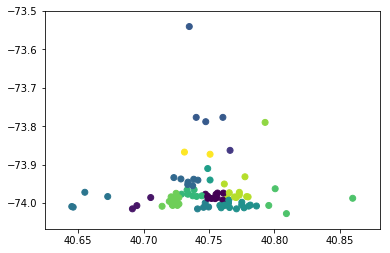

In [9]:
c, l = plotKMeans(lat[1000:1100], lon[10000:10090], 20, 20)

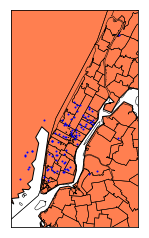

In [109]:
# setup mercator basemap.
lat = data['Lat'].tolist()
lon = data['Lon'].tolist()
man_coords = [40.6664, 40.8851, -74.0587, -73.8890]
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
m1=draw_basemap(lat[1:100], lon[1:100], man_coords, shapefiles) # plots raw points

In [5]:

test_small = createDiGraphK(data, 2000, 2)

In [27]:
def get_pos(G, m):
    pos = {}
    #lat = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lat').items()}
    #lon = {k:mean(v) for (k,v) in nx.get_node_attributes(test1, 'lon').items()}
    lt = nx.get_node_attributes(G, 'lat')
    ln = nx.get_node_attributes(G, 'lon')
    for node_num in list(G.nodes()):
        pos[node_num] = m(ln[node_num], lt[node_num]) # KEEP IN MIND THIS IS NOW X,Y
    return pos

In [341]:
def draw_graph(G, coords=[40.58, 40.88, -74.28, -73.840], shapefiles={}, node_size=50): 
    plt.figure(figsize=(18,12))
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='lightgreen',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = 'b', alpha=0.8,node_size=node_size)
    nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    plt.show()
    return m

In [22]:
shapefiles ={}
shapefiles['shapes/ZIP_CODE_N'] = 'zipcodes'
man_coords = [40.58, 40.88, -74.28, -73.840] #manhattan by default

In [309]:
test_all = createDiGraphK(data, len(data), k=30, iters=30)

FINISHED PROJ. COORDINATES...STARTING NODES


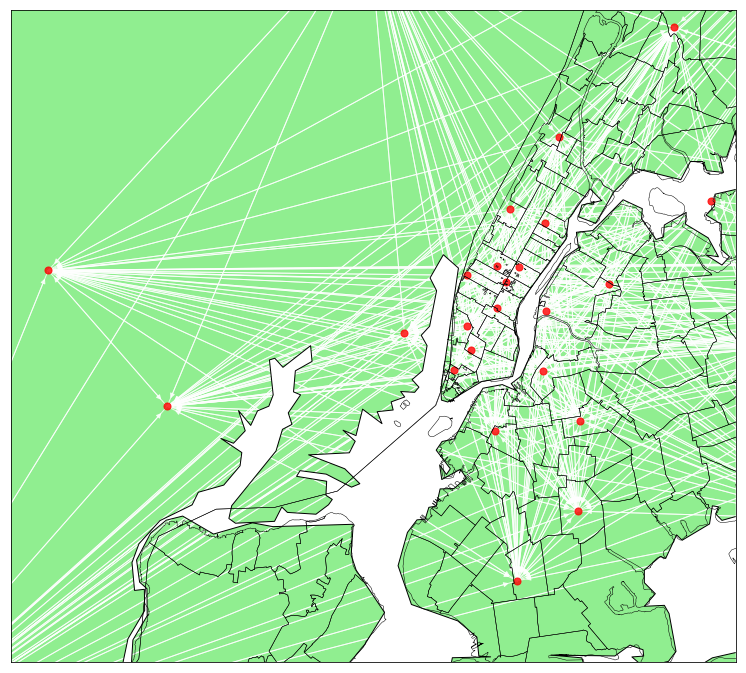

In [311]:
draw_graph(test_all, man_coords, shapefiles)

In [323]:
# scale graph 
node_lt = nx.get_node_attributes(test_all, 'lat').values()
node_ln = nx.get_node_attributes(test_all, 'lon').values()
pad = 0.01
c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]

FINISHED PROJ. COORDINATES...STARTING NODES


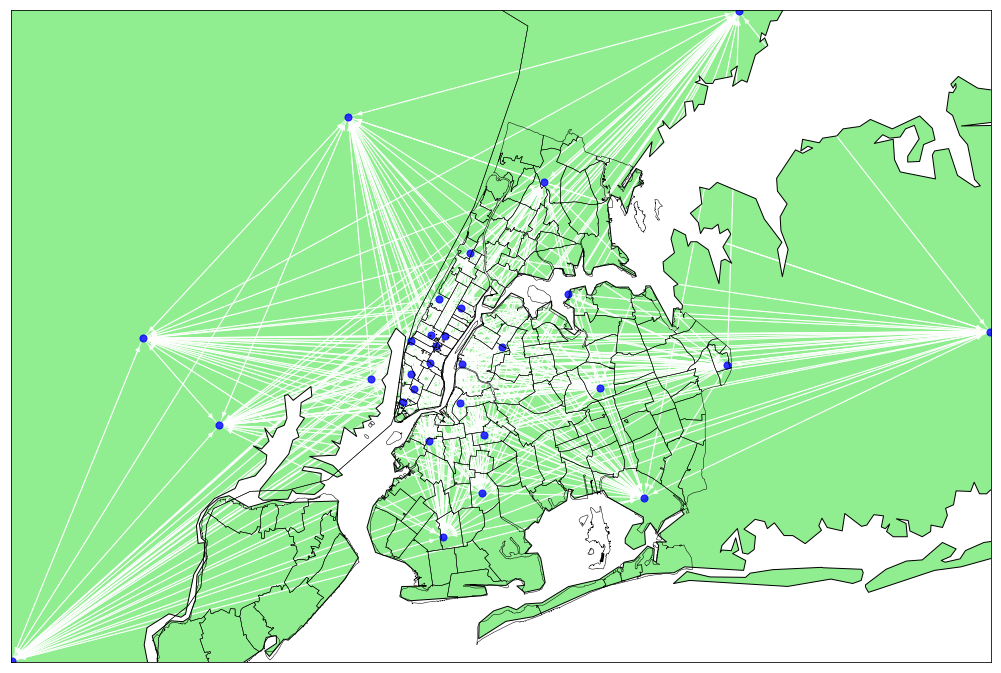

In [324]:
m3 = draw_graph(test_all, c2, shapefiles)

yay we got it visualized! now let's try to make the graph more meaningful by incorporating some of measures of centrality

In [333]:
def get_stats(G):
    stats = {};  
    stats['out_degrees'] = G.out_degree(weight='weight'); 
    stats['closeness_centrality'] = nx.closeness_centrality(G); # hard to do the rest of these because of uniform dist. 
    stats['betweenness_centrality'] = nx.betweenness_centrality(G); 
    stats['eigenvalue_centrality'] = nx.eigenvector_centrality(G); 
    stats['pagerank'] = nx.pagerank(G); 
    return stats

In [355]:
test_all.out_degree(weight='weight')

OutDegreeView({0: 35788, 1: 7877, 2: 815, 3: 16405, 4: 470, 5: 2616, 6: 76973, 7: 4255, 8: 7296, 9: 53172, 10: 191, 11: 11952, 12: 52686, 13: 152, 14: 3511, 15: 3989, 16: 37426, 17: 48205, 18: 51286, 19: 40369, 20: 6112, 21: 3100, 22: 4780, 23: 36379, 24: 440, 25: 18730, 26: 24593, 27: 675, 28: 11944, 29: 2329})

FINISHED PROJ. COORDINATES...STARTING NODES


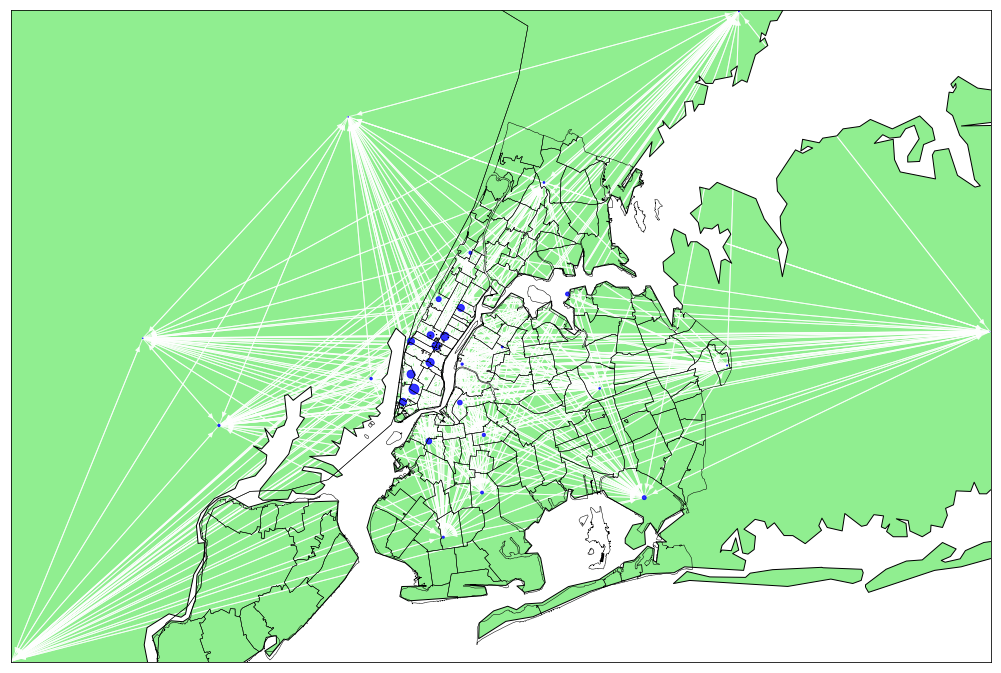

In [348]:
# adjust sizing of nodes based on their relative out-degrees
og_size =  400
sizes = []
for node in list(test_all.nodes()):
    sizes.append(og_size*0.5*(out_weights[node])/2.0)
draw_graph(test_all, c2, shapefiles, node_size=sizes)

In [66]:
def get_weighted_nodes(G, og_size):
    # get weights into the range [0.5-1]
    out_raw = dict(G.out_degree(weight='weight'))
    min_out = min(out_raw.values())
    max_out = max(out_raw.values())
    out_weights = {k:(v-min_out)/(max_out-min_out) for (k,v) in out_raw.items()}
    
    # adjust sizing of nodes based on their relative out-degrees
    sizes = []
    for node in list(G.nodes()):
        sizes.append(og_size*0.5*(out_weights[node]) + 0.5*og_size)
    return sizes

Hmmm so there's BARELY any usage of the outer nodes. let's try to remove some outliers...and add a function to scale the map if necessary

In [25]:
# remove outliers 
def removeOutliers(x, outlierConstant):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
    return resultList

In [26]:
# return indices of valid points-- SHOULD USE THIS INSTEAD WHEN CONSIDERING TWO RELATED SETS OF POINTS!!!
def getOutliers(x, y, outlierConstant):
    a = np.array(x)
    b = np.array(y)
    upper_quartile_a = np.percentile(a, 75)
    lower_quartile_a = np.percentile(a, 25)
    upper_quartile_b = np.percentile(b, 75)
    lower_quartile_b = np.percentile(b, 25)
    IQR_a = (upper_quartile_a - lower_quartile_a) * outlierConstant
    IQR_b = (upper_quartile_b - lower_quartile_b) * outlierConstant
    quartileSet_a = (lower_quartile_a - IQR_a, upper_quartile_a + IQR_a)
    quartileSet_b = (lower_quartile_b - IQR_b, upper_quartile_b + IQR_b)
    valid = []
    for i,v in enumerate(a.tolist()):
        if (v >= quartileSet_a[0] and v <= quartileSet_a[1] and b[i] >= quartileSet_b[0] and b[i] <= quartileSet_b[1]):
            valid.append(i)
    return valid

In [38]:
def createDiGraphK_clean(data, sample_size, k=40, iters=20, name='ktemp'):
    # cluster data using k-means
    valid_idx = np.array(getOutliers(data['Lat'], data['Lon'], 1))
    lat = np.array(data['Lat'])[valid_idx]
    lon = np.array(data['Lon'])[valid_idx]
    coordinates= np.array(list(zip(lat, lon)))
    centroids, labels = kmeans2(whiten(coordinates), k, iter = iters) 
    num_points = len(lat)
    # create graph with k nodes
    G = nx.DiGraph(); 
    for pick_up in range(0,min(sample_size, num_points)):
        
        # get k-means centroid from src and randomize dest based on uniform distribution among all clusters
        rand_idx = random.randint(0, num_points - 1)
        la = lat[rand_idx]
        lo = lon[rand_idx]
        src = labels[rand_idx]
        dest = random.randint(0, k - 1)
        if (dest == src and src != 0):
            dest = 0

        # increase edge weight from src -->  dest by 1 
        if not G.has_node(src):
            G.add_node(src, lat=0, lon=0)
        if not G.has_node(dest):
            G.add_node(dest, lat=0, lon=0)
        if not G.has_edge(src, dest):
            G.add_edge(src, dest, weight=0)
        G[src][dest]['weight'] += 1
        
        G.node[src]['lat'] = (G.node[src]['lat'] +  la) / 2 #keep a running average
        G.node[src]['lon'] =  (G.node[src]['lon'] +  lo) / 2
        
        #print("Adding edge from " + str(src) + " to " + str(dest))
        if (pick_up > 1000 and pick_up % 1000 == 0):
            nx.write_graphml(G, "graphs/" + name + ".graphml")
    return G 

In [63]:
def get_coords(G, pad=0.01):
    # scale graph 
    node_lt = nx.get_node_attributes(G, 'lat').values()
    node_ln = nx.get_node_attributes(G, 'lon').values()
    node_lt = list(filter(lambda x: x != 0, node_lt)) # FILTER OUT ZEROS BC OF A BUG Idk
    node_ln = list(filter(lambda x: x != 0, node_ln))
    c2 = [min(node_lt)-pad, max(node_lt)+pad, min(node_ln)-pad, max(node_ln)+pad]
    print(c2)
    return c2

In [61]:
def draw_graph_clean(G, coords=None, shapefiles={}, node_size=600): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='blanchedalmond',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = 'b', alpha=0.8,node_size=get_weighted_nodes(G, node_size))
    #nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
    plt.show()
    return m

In [64]:
g2 = createDiGraphK_clean(data, len(data), k=40, iters=40, name='k_all_uber')

KeyboardInterrupt: 

[40.68107447246062, 40.796818484718706, -74.03175597521343, -73.93642169899275]
FINISHED PROJ. COORDINATES...STARTING NODES


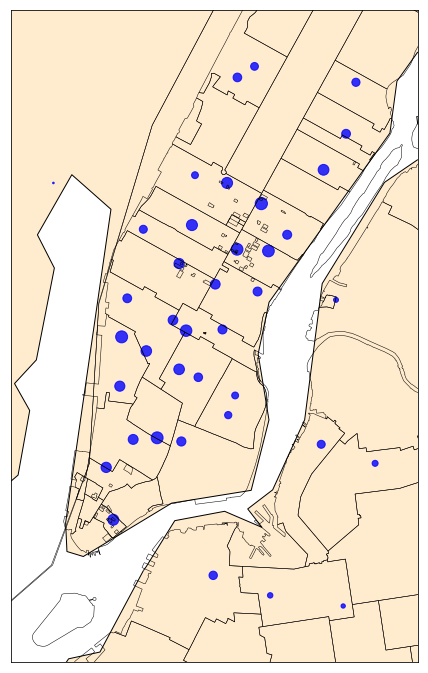

In [65]:
m2 = draw_graph_clean(g2, shapefiles=shapefiles)

ok lit. but what do these places actually mean? I wish we had more k-clusters...we could try finding the optimal k value that would minimize the "sum of squared distances"...but is that what we actually want? 

FINISHED PROJ. COORDINATES...STARTING NODES


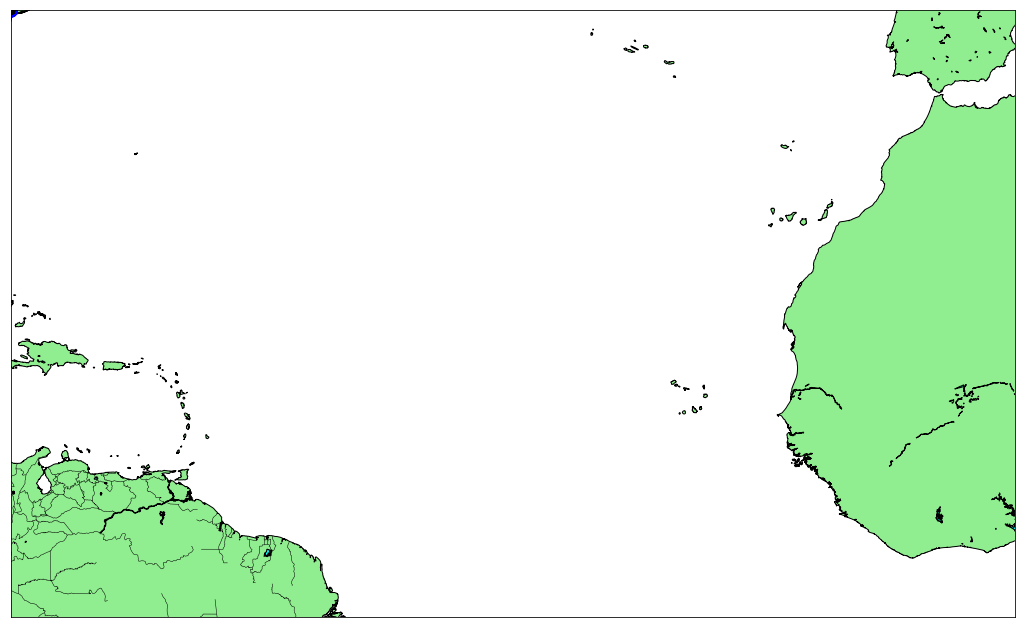

In [43]:
m2 = draw_graph_clean(g2, shapefiles=shapefiles)

In [12]:
# determine the optimal k-value 
def plot_k(data):
    K = range(20, 100, 5)
    inertia = []
    km = KMeans()
    for k in K:
        coordinates= np.array(list(zip(data['Lat'][1:10000], data['Lon'][1:10000])))
        km = KMeans(n_clusters=k)
        k_model = km.fit(coordinates)
        inertia.append(k_model.inertia_)
        
    plt.figure(figsize=(12,8))
    plt.plot(K, inertia, 'b.')
    plt.title("Inertia vs k")
    plt.xlabel("K")
    plt.ylabel("Inertia")
    plt.show()
    return inertia
    

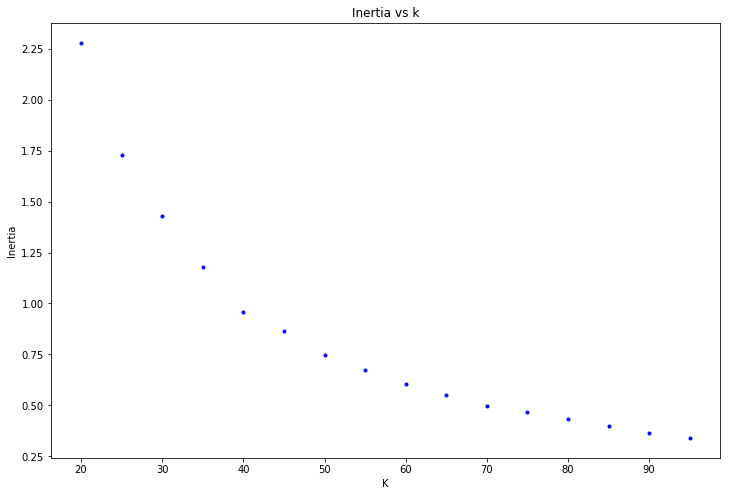

In [13]:
i = plot_k(data)

heyyyy so the "elbow" would be around 40-50, which is what we've been trying. nice

okay so trying to increase kvalues gives us more nodes to consider...but do we need that? idk, since there's no geographical relevance here so far. Also the edge weights rn are kinda visually meaningless so let's try to fix that -> maybe we can model CONGESTION by considering the amount of trips between each node

ok well we are actually still unsure of the relationship between the out/in-degree distributions, so the edges right now are not as relevant. maybe let's focus on analyzing solely the pickup locations for this dataset

In [70]:
# get  some colors
def draw_graph_clean_colors(G, coords=None, shapefiles={}, node_size=600): 
    plt.figure(figsize=(18,12))
    if coords is None:
        coords = get_coords(G)
    m = Basemap(projection='merc',llcrnrlat=coords[0],urcrnrlat=coords[1],llcrnrlon=coords[2], urcrnrlon=coords[3], resolution='h')
    m.drawcoastlines()
    m.drawstates()
    m.fillcontinents(color='blanchedalmond',lake_color='aqua')
    #m = Basemap(projection='merc', width=10, height=10, lat_0=40.783058, lon_0=-73.971252)
    pos = get_pos(G, m)
    
    # create networkx graph 
    print("FINISHED PROJ. COORDINATES...STARTING NODES")
    cmap = plt.cm.Blues
    nx.draw_networkx_nodes(G = G, pos = pos, node_color = get_weighted_nodes(G, 1.0), alpha=0.8,
                           node_size=get_weighted_nodes(G, node_size), cmap=cmap)
    #nx.draw_networkx_edges(G = G, pos = pos, edge_color='white', alpha=0.8, arrows = True)
    for file, name in shapefiles.items():
        m.readshapefile(file, name)
        
    # set colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    
    plt.show()
    return m

[40.68040258439974, 40.8054502842183, -74.02433118610789, -73.93755946089878]
FINISHED PROJ. COORDINATES...STARTING NODES


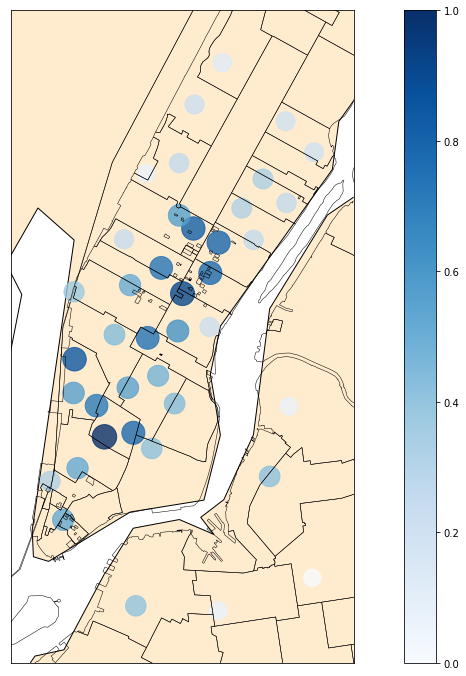

In [72]:
kgraph = nx.read_graphml('graphs/k_all_uber.graphml')
g4 = draw_graph_clean_colors(kgraph, shapefiles=shapefiles)

## now time for taxi dataset! 